# ogbg-molhiv-smiles

This notebook try to convert the `ogbg-molhiv` to the `smiles` formate of the graphs.

Let's make it clear what is `smiles` and what is `ogbg-molhiv`.
- `ogbg-molhiv`: It is a molecular graph dataset which is standardized for benchmarking the results on the graph formate of the molecular data.
- `smiles`: It is the unique string representation of the molecules.

Also, to be on the same page, our goal on this project is to do the classification task on the graph representation of the moleculs.

## Step 1: Download and Load the dataset

Using `PygGraphPropPredDataset` class to download the dataset

In [2]:
from ogb.graphproppred import GraphPropPredDataset, PygGraphPropPredDataset

dataset_name = 'ogbg-molhiv'
dataset = PygGraphPropPredDataset(name=dataset_name, root='../dataset')

### 1.1: Check Dataset Info
Check basic dataset information using `PyG`

In [3]:
print(f"len(dataset): {len(dataset)} <- number of graphs")
print(f"dataset.num_classes: {dataset.num_classes} <- number of labels for classes")
print(
    f"dataset.num_node_features: {dataset.num_node_features} <- number of features for each node of graphs"
)
print(
    f"dataset.num_edge_features: {dataset.num_edge_features} <- number of features for each edge of graphs"
)

len(dataset): 41127 <- number of graphs
dataset.num_classes: 2 <- number of labels for classes
dataset.num_node_features: 9 <- number of features for each node of graphs
dataset.num_edge_features: 3 <- number of features for each edge of graphs


#### Edge Features: from the documention on the [ogbg-molhiv code](https://github.com/snap-stanford/ogb/blob/f631af76359c9687b2fe60905557bbb241916258/ogb/utils/features.py#L20C4-L35C50), we found the following description for the edge features.

- `possible_bond_type_list`: Bond type between two atoms or nodes
    - `SINGLE` bond: A single bond is a covalent bond in which two atoms share one pair of electrons. It's represented by a single line (-) between the atoms.
    - `DOUBLE` bond: A double bond is a covalent bond in which two pairs of electrons are shared between two atoms. It's represented by a double line (=) between the atoms.
    - `TRIPLE` bond: A triple bond is a covalent bond in which three pairs of electrons are shared between two atoms. It's represented by a triple line (≡) between the atoms.
    - `AROMATIC` bond: An aromatic bond is a special type of bond found in molecules with aromatic rings, such as benzene. These bonds exhibit resonance and delocalization of electrons, leading to enhanced stability of the molecule. Aromatic bonds are typically represented by a circle inside a hexagon.
    - Miscellaneous (`misc`) bond: This category might include various other types of bonds that don't fit neatly into the above categories. It could encompass unconventional or less common bond types, such as coordinate bonds or bonds involving transition metals, among others.
- `possible_bond_stereo_list`: Bond stereochemistry refers to the spatial arrangement of atoms or groups around a particular bond in a molecule. It's concerned with how different substituents or atoms are positioned relative to each other in three-dimensional space. This spatial arrangement can have significant effects on the properties and behavior of molecules, especially in terms of their reactivity and biological activity.

    - `STEREONONE`: This term indicates that there is no specific stereochemistry associated with the bond. It means that the atoms or groups attached to the bond do not have a defined spatial arrangement relative to each other. In other words, the molecule does not exhibit any stereochemical properties at that particular bond.

    - `STEREOZ`: This term refers to a type of bond stereochemistry where the higher priority substituents are on the same side of the bond. The "Z" notation comes from the German word "zusammen," meaning "together." It is also known as cis configuration.

    - `STEREOE`: This term refers to a type of bond stereochemistry where the higher priority substituents are on opposite sides of the bond. The "E" notation comes from the German word "entgegen," meaning "opposite." It is also known as trans configuration.

    - `STEREOCIS`: This term specifically describes a cis configuration where the higher priority substituents are on the same side of the bond. It indicates a specific geometric arrangement where the substituents are closer together.

    - `STEREOTRANS`: This term specifically describes a trans configuration where the higher priority substituents are on opposite sides of the bond. It indicates a specific geometric arrangement where the substituents are farther apart.

    - `STEREOANY`: This term indicates that the bond can have any stereochemical configuration. It means that the molecule is not restricted to a specific arrangement of substituents around the bond, and various stereochemical configurations are possible.
- `possible_is_conjugated_list`: Absorptive of light
    - `False`
    - `True`

### 1.2 Check Graph Info
Check basic graph information using `PyG`

In [4]:
from tabulate import tabulate
from torch_geometric.data import Data

graph_number = 0
graph: Data = dataset[graph_number]

table = [
    ["Graph #", graph_number],
    ["Graph Object", graph],
    ["", ""],
    ["graph.num_nodes", graph.num_nodes],
    ["graph.num_edges", graph.num_edges],
    ["graph.has_isolated_nodes", graph.has_isolated_nodes()],
    ["graph.has_self_loops", graph.has_self_loops()],
    ["graph.is_directed", graph.is_directed()],
    ["graph.x.shape", graph.x.shape],
    ["graph.x", graph.x],
    ["graph.y.shape", graph.y.shape],
    ["graph.y", graph.y],
    ["graph.edge_attr.shape", graph.edge_attr.shape],
    ["graph.edge_attr", graph.edge_attr],
    ["graph.edge_index.shape", graph.edge_index.shape],
    ["graph.edge_index", graph.edge_index],
]

print(tabulate(table, headers=["Property", "Value"], tablefmt="grid"))


+--------------------------+----------------------------------------------------------------------------------+
| Property                 | Value                                                                            |
+==========================+==================================================================================+
| Graph #                  | 0                                                                                |
+--------------------------+----------------------------------------------------------------------------------+
| Graph Object             | Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)   |
+--------------------------+----------------------------------------------------------------------------------+
+--------------------------+----------------------------------------------------------------------------------+
| graph.num_nodes          | 19                                                                         

### 1.3 Dataset Scaffolded Split
Using `PyG` scaffolded splited dataset we have pre-defined __train__, __validation__ and __test__ sub-datasets.

In [5]:
train_idxes = dataset.get_idx_split().get('train')
valid_idxes = dataset.get_idx_split().get('valid')
test_idxes = dataset.get_idx_split().get('test')
train_pyg_graphs = [dataset[i] for i in train_idxes]
valid_pyg_graphs = [dataset[i] for i in valid_idxes]
test_pyg_graphs = [dataset[i] for i in test_idxes]

In [6]:
total_size = len(train_pyg_graphs) + len(valid_pyg_graphs) + len(test_pyg_graphs)
train_percentage = (len(train_pyg_graphs) / total_size) * 100
valid_percentage = (len(valid_pyg_graphs) / total_size) * 100
test_percentage = (len(test_pyg_graphs) / total_size) * 100

table = [
    ["Dataset", "Size", "Percentage"],
    ["Train", len(train_pyg_graphs), f"{train_percentage:.2f}%"],
    ["Validation", len(valid_pyg_graphs), f"{valid_percentage:.2f}%"],
    ["Test", len(test_pyg_graphs), f"{test_percentage:.2f}%"]
]

print(tabulate(table, headers="firstrow", tablefmt="grid"))

+------------+--------+--------------+
| Dataset    |   Size | Percentage   |
+============+========+==============+
| Train      |  32901 | 80.00%       |
+------------+--------+--------------+
| Validation |   4113 | 10.00%       |
+------------+--------+--------------+
| Test       |   4113 | 10.00%       |
+------------+--------+--------------+


## Step 2: Convert `pyg` graphs to `networkx` graphs

Using our helper function `pyg_to_networkx()`, we make also the `networkx` graphs version of the dataset. 

In [7]:
import sys
sys.path.append('..')  # Add parent directory to Python path

from utils.utils import pyg_to_networkx

train_nx_graphs = [pyg_to_networkx(i) for i in train_pyg_graphs]
valid_nx_graphs = [pyg_to_networkx(i) for i in valid_pyg_graphs]
test_nx_graphs = [pyg_to_networkx(i) for i in test_pyg_graphs]

## Step 3: Get `SMILES` version of graphs

Using the secondary dataset, we get and concate the `SMILES` or string version of the graphs. 

In [8]:
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Lipinski import *
from rdkit.Chem.AtomPairs import Torsions, Pairs
from rdkit.Chem import MACCSkeys 
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem import MACCSkeys 
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from tqdm import tqdm
from ogb.graphproppred import GraphPropPredDataset
from tqdm import tqdm

smile_data = pd.read_csv(f"../dataset/ogbg_molhiv/mapping/mol.csv.gz".replace("-", "_"))
smile_data.drop(["mol_id"], axis = 1, inplace=True)
mol = [Chem.MolFromSmiles(x) for x in tqdm(smile_data.smiles)]
smile_data['mol'] = mol
train_dataset = smile_data.iloc[train_idxes]
train_dataset['nx_graph'] = train_nx_graphs
train_dataset['pyg_graph'] = train_pyg_graphs
train_dataset['num_nodes'] = train_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_nodes)
train_dataset['num_edges'] = train_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_edges)
valid_dataset = smile_data.iloc[valid_idxes]
valid_dataset['nx_graph'] = valid_nx_graphs
valid_dataset['pyg_graph'] = valid_pyg_graphs
valid_dataset['num_nodes'] = valid_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_nodes)
valid_dataset['num_edges'] = valid_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_edges)
test_dataset = smile_data.iloc[test_idxes]
test_dataset['nx_graph'] = test_nx_graphs
test_dataset['pyg_graph'] = test_pyg_graphs
test_dataset['num_nodes'] = test_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_nodes)
test_dataset['num_edges'] = test_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_edges)


 84%|████████▎ | 34368/41127 [00:04<00:00, 7772.54it/s][11:45:28] WARNING: not removing hydrogen atom without neighbors
[11:45:28] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 41127/41127 [00:05<00:00, 7803.18it/s]


In [9]:
train_dataset.head()

,HIV_active,smiles,mol,nx_graph,pyg_graph,num_nodes,num_edges
3,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",24,50
4,0,O=S(=O)(O)CCS(=O)(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 1, 4,...",10,18
5,0,CCOP(=O)(Nc1cccc(Cl)c1)OCC,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",16,32
6,0,O=C(O)c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 3, 4,...",10,20
8,0,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,...",26,54


There is good visualization of the `Molecules` in `rdkit` library.

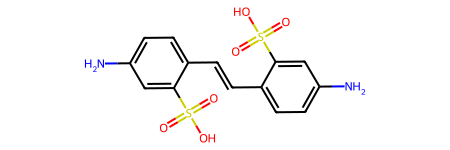

In [10]:
train_dataset.iloc[0].mol

## Step 4: Extract `Molecular` Features from the `SMILE` string

### 4.1: Morgan Fingerprint


In [11]:
def morgan_fp(mol):
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol ,radius = 3, nBits=3*1024), dtype= np.int8)

train_dataset['morgan_fp'] = train_dataset['mol'].apply(lambda mol: morgan_fp(mol))
valid_dataset['morgan_fp'] = valid_dataset['mol'].apply(lambda mol: morgan_fp(mol))
test_dataset['morgan_fp'] = test_dataset['mol'].apply(lambda mol: morgan_fp(mol))

### 4.2: RDKit-FP

In [12]:
def rdkit_fp(mol):
    return np.array(Chem.RDKFingerprint(mol, maxPath = 5, bitInfo={}), dtype= np.int8)

train_dataset['rdkit_fp'] = train_dataset['mol'].apply(lambda mol: rdkit_fp(mol))
valid_dataset['rdkit_fp'] = valid_dataset['mol'].apply(lambda mol: rdkit_fp(mol))
test_dataset['rdkit_fp'] = test_dataset['mol'].apply(lambda mol: rdkit_fp(mol))

In [13]:
train_dataset.head()

,HIV_active,smiles,mol,nx_graph,pyg_graph,num_nodes,num_edges,morgan_fp,rdkit_fp
3,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",24,50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,O=S(=O)(O)CCS(=O)(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 1, 4,...",10,18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0,CCOP(=O)(Nc1cccc(Cl)c1)OCC,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",16,32,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,0,O=C(O)c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 3, 4,...",10,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,0,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,<rdkit.Chem.rdchem.Mol object at 0x0000025EB0A...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,...",26,54,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 5: EDA

32901


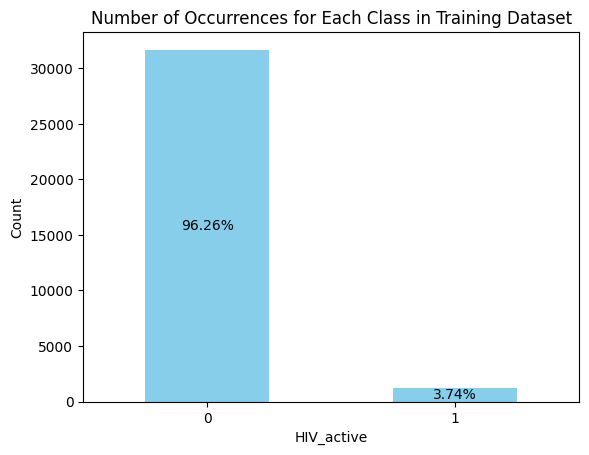

In [14]:
import matplotlib.pyplot as plt

# Add this line to display plots inline
%matplotlib inline

print(len(train_dataset['HIV_active']))

# Plot the number of occurrences for each class
class_counts = train_dataset['HIV_active'].value_counts()
ax = class_counts.plot(kind='bar', rot=0, color='skyblue')

# Annotate each bar with its percentage
total = len(train_dataset['HIV_active'])
for i, count in enumerate(class_counts):
    percentage = count / total * 100
    plt.text(i, count / 2, f'{percentage:.2f}%', ha='center', va='center')

plt.title('Number of Occurrences for Each Class in Training Dataset')
plt.xlabel('HIV_active')
plt.ylabel('Count')
plt.show()

In [15]:
for column in ['morgan_fp','rdkit_fp']:
    print(len(train_dataset[column].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) else x).unique()))

32735
31638


## 5: RF & XGBoost

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from ogb.graphproppred import Evaluator
from xgboost import XGBClassifier
from tabulate import tabulate

import seaborn as sns

def customRandomForest(feature_column, tag_column, param_grid, mode='randomForest', cV=5, random_state=42):
    '''
    input: feature_column, tag_column, param_grid, 'randomForest'/'xGBoost', cv, random_state 

    rf example:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10],
        'class_weight': ['balanced']
    }

    xgb example:
    param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    }
    '''

    # Separate features and target
    X_train = np.vstack(train_dataset[feature_column].values)
    y_train = train_dataset[tag_column].values

    X_valid = np.vstack(valid_dataset[feature_column].values)
    y_valid = valid_dataset[tag_column].values

    X_test = np.vstack(test_dataset[feature_column].values)
    y_test = test_dataset[tag_column].values

    #############################################################################################################

    if mode == 'randomForest':
        # Create a RandomForestClassifier
        print("RandomForest model selected...")
        classifier = RandomForestClassifier(random_state)

    elif mode == 'xGBoost':
        print("xGBoost model selected...")
        # Create XGBoost classifier
        classifier = XGBClassifier(random_state)

    # Define the F1 score as the scoring metric for the grid search
    scorer = make_scorer(custom_scorer, greater_is_better=True)

    # Create GridSearchCV object
    print(f"Creating the GSCV with params: {param_grid} and cv: {cV}")
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scorer, cv=StratifiedKFold(n_splits=cV), n_jobs=-1)

    # Perform the grid search on the training data
    print("Training...")
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters found for {mode} based on rocauc: {best_params}")
    print("#########################################################")

    # Get the best model
    best_model = grid_search.best_estimator_

    predict(best_model, X_valid, y_valid, X_test, y_test)

    # Parse classification report and create a table
    def create_classification_report_table(report):
        lines = report.split('\n')
        header = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']
        data = []
        for line in lines[2:-3]:
            t = line.strip().split()
            if len(t) == 5:
                data.append([t[0], t[1], t[2], t[3], t[4]])
        return tabulate(data, headers=header, tablefmt='grid')
    
    # Confusion Matrix
    def plot_confusion_matrix(conf_matrix, title='Confusion Matrix', cmap=plt.cm.Blues):
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap)
        plt.title(title)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()
        
    def custom_scorer(y_true, y_pred):
        evaluator = Evaluator(name = "ogbg-molhiv")
        result_dict = evaluator.eval({"y_true": np.vstack(y_true), "y_pred": np.vstack(y_pred)})
        return  result_dict['rocauc']
    
    def predict(best_model, X_valid, y_valid, X_test, y_test):

        evaluator = Evaluator(name = "ogbg-molhiv")

        print("Evaluating the model with validation dataset:")

        # Make predictions on the test set using the best model
        y_pred_valid = best_model.predict(X_valid)

        print(f'Accuracy on validation: {accuracy_score(y_valid, y_pred_valid)}')
        plot_confusion_matrix(confusion_matrix(y_valid, y_pred_valid))
        print(f'classification erport for validation dataset:')
        print(create_classification_report_table(classification_report(y_valid, y_pred_valid)))

        result_dict_valid = evaluator.eval({"y_true": np.vstack(y_valid), "y_pred": np.vstack(y_pred_valid)})
        print(f'Best rocauc found on validation dataset using the params:\n{result_dict_valid}')
        print("#########################################################")

        #############################################################################################################

        print("Evaluating the model with test dataset:")

        # Make predictions on the test set using the best model
        y_pred_test = best_model.predict(X_test)

        print(f'Accuracy on test: {accuracy_score(y_test, y_pred_test)}')
        plot_confusion_matrix(confusion_matrix(y_test, y_pred_test))
        print(f'classification report on test dataset:')
        print(create_classification_report_table(classification_report(y_test, y_pred_test)))

        result_dict_test = evaluator.eval({"y_true": np.vstack(y_test), "y_pred": np.vstack(y_pred_test)})
        print(f'Best rocauc found on test dataset using the params:\n{result_dict_test}')


RandomForest model selected...
Creating the GSCV with params: {'n_estimators': [50], 'class_weight': ['balanced']} and cv: 2
Training...
Best Hyperparameters found for randomForest based on rocauc: {'class_weight': 'balanced', 'n_estimators': 50}
#########################################################
Evaluating the model with validation dataset:
Accuracy on validation: 0.9824945295404814


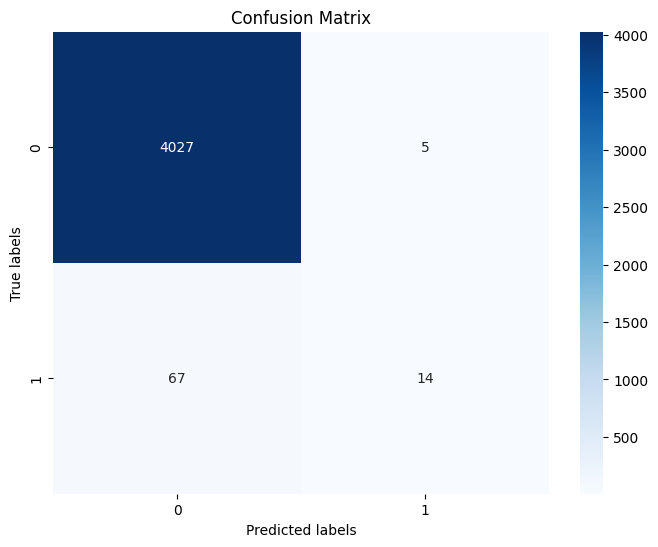

classification erport for validation dataset:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+============+===========+
|       0 |        0.98 |     1    |       0.99 |      4032 |
+---------+-------------+----------+------------+-----------+
|       1 |        0.74 |     0.17 |       0.28 |        81 |
+---------+-------------+----------+------------+-----------+
Best rocauc found on validation dataset using the params:
{'rocauc': 0.5857997134038799}
#########################################################
Evaluating the model with test dataset:
Accuracy on test: 0.9708242159008024


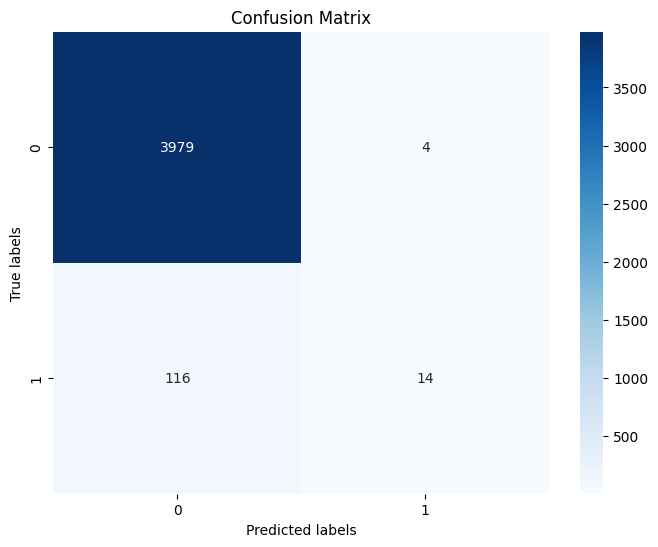

classification report on test dataset:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+============+===========+
|       0 |        0.97 |     1    |       0.99 |      3983 |
+---------+-------------+----------+------------+-----------+
|       1 |        0.78 |     0.11 |       0.19 |       130 |
+---------+-------------+----------+------------+-----------+
Best rocauc found on test dataset using the params:
{'rocauc': 0.5533440197763573}


In [37]:
param_grid = {
    'n_estimators': [50],
    'class_weight': ['balanced']
}
customRandomForest('morgan_fp', 'HIV_active', param_grid, 'randomForest', cV=2)

In [75]:
param_grid = {
    'n_estimators': [50,100],
    'class_weight': ['balanced']
}
customRandomForest('rdkit_fp', 'HIV_active', param_grid, 'randomForest')

Best Hyperparameters: {'class_weight': 'balanced', 'n_estimators': 100}
#########################################################
accuracy_valid: 0.9817651349380014
conf_matrix_valid:
[[4028    4]
 [  71   10]]
classification_rep_valid:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4032
           1       0.71      0.12      0.21        81

    accuracy                           0.98      4113
   macro avg       0.85      0.56      0.60      4113
weighted avg       0.98      0.98      0.98      4113

rocauc:
{'rocauc': 0.5612323633156967}
#########################################################
accuracy_test: 0.9688791636275225
conf_matrix_test:
[[3970   13]
 [ 115   15]]
classification_rep_test:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3983
           1       0.54      0.12      0.19       130

    accuracy                           0.97      4113
   macro avg     

In [19]:
param_grid = {
'n_estimators': [50, 100],
}
customRandomForest('morgan_fp', 'HIV_active', param_grid, 'xGBoost')

Best Hyperparameters: {'n_estimators': 100}
#########################################################
accuracy_valid: 0.9822513980063214
conf_matrix_valid:
[[4027    5]
 [  68   13]]
classification_rep_valid:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4032
           1       0.72      0.16      0.26        81

    accuracy                           0.98      4113
   macro avg       0.85      0.58      0.63      4113
weighted avg       0.98      0.98      0.98      4113

rocauc:
{'rocauc': 0.5796268738977073}
#########################################################
accuracy_test: 0.9715536105032823
conf_matrix_test:
[[3977    6]
 [ 111   19]]
classification_rep_test:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3983
           1       0.76      0.15      0.25       130

    accuracy                           0.97      4113
   macro avg       0.87      0.57      0.62  